# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, we will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. we'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, we'll apply what we've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that we will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


## Table of Contents -- DUMMY
<ul>
<li><a href="#part0">Part 0: Get to Know the Data</a></li>
<li><a href="#part1">Part 1: Customer Segmentation Report</a></li>
<li><a href="#part2">Part 2: Supervised Learning Model</a></li>
</ul>



In [276]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import time
import pickle


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics

# magic word for producing visualizations in notebook
%matplotlib inline

# to show all the rows and columns for large data. But be carefull about printing the results
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

<a id='part0'></a>
## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. 

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that our final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the repo. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

***AIM:*** We will use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use our analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.


Before we really start digging into the modeling and analysis, we're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/esraari/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Descriptive Analysis

In [5]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

As it can be seen there are so many features to analyze. To gain some time, we may want to eliminate less important features while looking at missing ratio. Higher missing ratio leads to low information gain so may consider to drop these features.

## Missing value investigation
### Data cleaning

In [6]:
df_missing = azdias.isnull().sum().reset_index().rename(columns={'index':'column_names', 0:'n_missing'})

In [7]:
df_missing.head()

,column_names,n_missing
0,LNR,0
1,AGER_TYP,0
2,AKT_DAT_KL,73499
3,ALTER_HH,73499
4,ALTER_KIND1,810163


In [8]:
len(df_missing[df_missing.n_missing==0])

93

It is intesting that we have 93 feature with completely filled values. So I have checked the excel file, it seems that there are features with special values which means that some of missing values are assigned to spesific value. So we need to do conversion to calculate missing ratios correctly.

In [97]:
values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 1).fillna(method = 'ffill').iloc[:,1:]
infos = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header = 1).fillna(method = 'ffill').iloc[:,1:]

In [165]:
values[values['Attribute']=='AGER_TYP']

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


AGER_TYP attribute is missing if the value is -1. So we need to convert all values accordingly with this excel.

In [274]:
dict_missing_values = values[values['Meaning'] == 'unknown'][['Attribute', 'Value']].set_index('Attribute').T.to_dict(orient='list')

azdias_cleaned = azdias.copy()
for key, value in dict_missing_values.items():
    try:
        azdias_cleaned[key].replace(dict_missing_values[key], np.nan, inplace=True)
    except:
        print(key)
        continue


BIP_FLAG
CAMEO_DEUINTL_2015
D19_KK_KUNDENTYP
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
KBA13_CCM_1400_2500
SOHO_FLAG
WACHSTUMSGEBIET_NB


In [167]:
#Check
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [168]:
#Check
azdias_cleaned['AGER_TYP'].value_counts()

2.0    98472
1.0    79802
3.0    27104
0.0     8340
Name: AGER_TYP, dtype: int64

Seems that we have cleaned the data. -1 value assigned as nan.BIP_FLAG,
CAMEO_DEUINTL_2015,
D19_KK_KUNDENTYP,
GEOSCORE_KLS7,
HAUSHALTSSTRUKTUR,
KBA13_CCM_1400_2500,
SOHO_FLAG,
WACHSTUMSGEBIET_NB these 8 columns throw error because they are not in main dataframe.

In [169]:
df_missing_new = azdias_cleaned.isnull().sum().reset_index().rename(columns={'index':'column_names', 0:'n_missing'})
df_missing_new['missing_ratio'] = df_missing_new['n_missing']/len(azdias_cleaned)

In [170]:
df_missing_new.sort_values(by='missing_ratio', ascending=False).head(20)

,column_names,n_missing,missing_ratio
7,ALTER_KIND4,890016,0.998648
6,ALTER_KIND3,885051,0.993077
5,ALTER_KIND2,861722,0.966900
4,ALTER_KIND1,810163,0.909048
1,AGER_TYP,677503,0.760196
100,EXTSEL992,654153,0.733996
300,KK_KUNDENTYP,584612,0.655967
8,ALTERSKATEGORIE_FEIN,262947,0.295041
61,D19_LETZTER_KAUF_BRANCHE,257113,0.288495
53,D19_GESAMT_ONLINE_QUOTE_12,257113,0.288495


It seems that we don't have that many missing columns. We can drop if they are higher than %20. So we will drop 17 attributes.

In [171]:
lst_missing_attributes_dropped = list(df_missing_new[df_missing_new.missing_ratio>0.2].column_names)
print(len(lst_missing_attributes_dropped))
print(lst_missing_attributes_dropped)

17
['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']


Still we have so many missing features. We may want to drop highly cardinal variables. Because, most of ml algorithm requires one-hot encoding to use categorical variables. So that high caridnal variable creates issue in that sense.

In [172]:
cat_columns = azdias_cleaned.select_dtypes(['object']).columns
azdias_cleaned[cat_columns].describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,792242,792242,792242,634108,798073,798073
unique,45,19,43,35,5162,2
top,6B,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,56672,78023,77576,195338,383738,629528


* **CAMEO_DEUG_2015:** CAMEO classification 2015 - Uppergroup. It is like some kind of classification we may want to keep it.
* **CAMEO_DEU_2015:** CAMEO classification 2015 - detailled classification. We can drop it because we already have upper group segmentation
* **CAMEO_INTL_2015:** we dont' have info about this feature we can drop it.
* **D19_LETZTER_KAUF_BRANCHE:** we dont' have info about this feature we can drop it.
* **EINGEFUEGT_AM** we have so many feature so we can drop time related attributes.
* **OST_WEST_KZ:** flag indicating the former GDR/FRG. We can convert it to numerical attribute

In [173]:
lst_categorical_attributes_dropped = ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

We have 4 dataframe, so we need to drop non-common features

In [176]:
azdias_columns = set(azdias.columns)
customers_columns = set(customers.columns)
mailout_train_columns = set(mailout_train.columns)
mailout_test_columns = set(mailout_test.columns)


In [178]:
mailout_train_columns - mailout_train_columns.intersection(mailout_test_columns)

{'RESPONSE'}

In [179]:
mailout_train_columns.symmetric_difference(mailout_test_columns)

{'RESPONSE'}

In [181]:
azdias_columns.symmetric_difference(customers_columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [200]:
mailout_train_columns.symmetric_difference(customers_columns) 


{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'RESPONSE'}

In [199]:
non_common_attributes1 = mailout_train_columns.symmetric_difference(mailout_test_columns)
non_common_attributes2 = azdias_columns.symmetric_difference(customers_columns)
non_common_attributes3 = mailout_train_columns.symmetric_difference(customers_columns)

lst_non_common_attributes_dropped = non_common_attributes1 | non_common_attributes2 | non_common_attributes3
lst_non_common_attributes_dropped

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'RESPONSE'}

## Investigate missing rows

In [299]:
missing_analysis_df = azdias_cleaned.isnull().sum(axis=1).reset_index().rename(columns={'index':'n_missing_rows', 0:'n_missing_columns'}).groupby('n_missing_columns').count().reset_index()

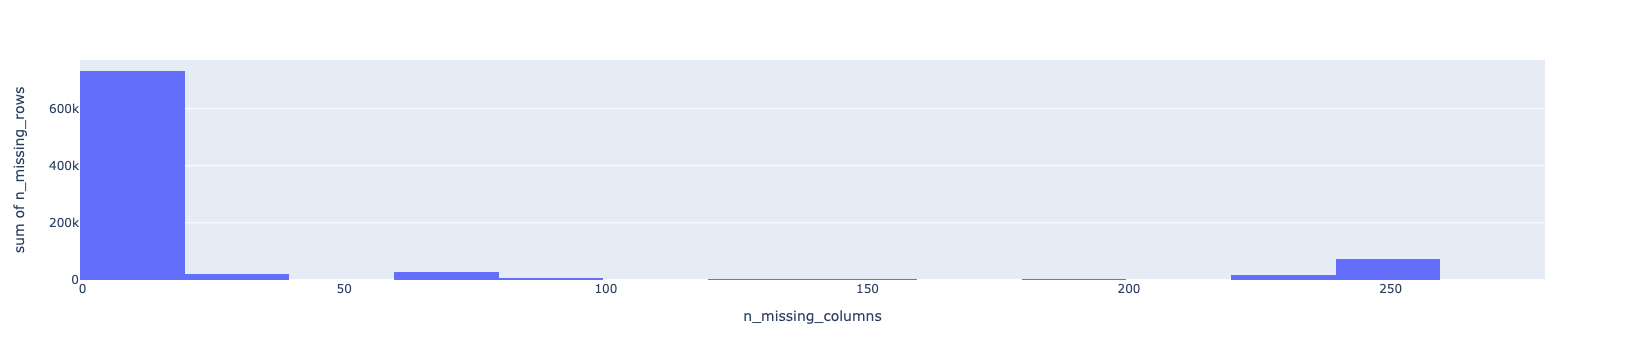

In [300]:
fig = px.histogram(missing_analysis_df, x='n_missing_columns', y='n_missing_rows')
fig.show()

In [296]:
azdias_cleaned.isnull().sum(axis=1).reset_index().rename(columns={'index':'n_missing_rows', 0:'n_missing_columns'}).groupby('n_missing_columns').count().reset_index().head()

,n_missing_columns,n_missing_rows
0,0,20
1,1,403
2,2,2028
3,3,8042
4,4,66907


I seems that majority of the population have 0-19 missing columns. To be sure on this lets do it by cumulatively.


In [307]:
df_cum_missing = missing_analysis_df.sort_values(by='n_missing_columns', ascending=True).set_index('n_missing_columns').cumsum().reset_index()

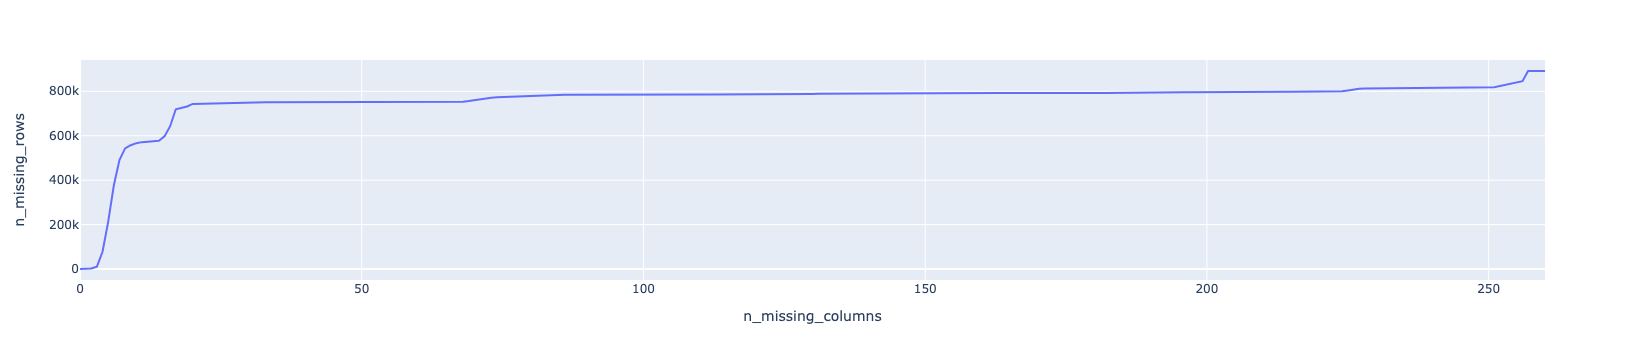

In [310]:
fig = px.line(df_cum_missing, x='n_missing_columns', y='n_missing_rows')
fig.show()

After 21 trend noramlzies so we can choose 21 for missing rows alimanation

In [ ]:
df_missing_cum = (azdias_null_rows.value_counts().sort_index().cumsum()/len(azdias)) * 100

In [204]:
def data_cleaning(df, values, is_test_df=False):
    """ Does basic data cleaning operations like dropping high missing/cardinal/noncommon columns, misssing inputations, dropping missign rows, and most importanly missing transformations
    Input:
    df - Dataframe to e cleaned
    values - values dataframe extracted from DIAS Attributes - Values 2017 excel file
    is_test_df  - boolean whether sent df is test df. We shouldn't drop the rows for test dataframe. 
    
    Output:
    df_cleaned - clenaed DataFrame
    """
    # copy of df
    df_cleaned=df.copy()
    
    # Missing attributes found in missing anaysis section
    lst_missing_attributes_dropped = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
    # High Cardinal attributes
    lst_categorical_attributes_dropped = ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
    # Non common attributes
    lst_non_common_attributes_dropped = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
    
    #UPDATED: drop correlated features
    lst_correlated_attributes_dropped = ['ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP_RASTER', 'GEMEINDETYP', 'INNENSTADT', 'KBA05_AUTOQUOT', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MOD1', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MOTOR', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_BJ_2000', 'KBA13_BJ_2006', 'KBA13_GBZ', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_66', 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_SONST', 'KBA13_HHZ', 'KBA13_KMH_140', 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KW_30', 'KBA13_KW_61_120', 'KBA13_MERCEDES', 'KBA13_OPEL', 'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_VAN', 'KBA13_SITZE_5', 'KBA13_VORB_1', 'KBA13_VORB_2', 'KBA13_VW', 'KONSUMZELLE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'ORTSGR_KLS9', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'SEMIO_KAEM', 'SEMIO_KULT', 'SEMIO_REL', 'SEMIO_VERT','STRUKTURTYP', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'WOHNDAUER_2008','ANREDE_KZ', 'ALTERSKATEGORIE_GROB']
    
    lst_attributes_dropped = []
    lst_attributes_dropped.extend(set(lst_missing_attributes_dropped))
    lst_attributes_dropped.extend(set(lst_categorical_attributes_dropped))
    lst_attributes_dropped.extend(set(lst_non_common_attributes_dropped))
    lst_attributes_dropped.extend(set(lst_correlated_attributes_dropped))
    lst_attributes_dropped = [x for x in lst_attributes_dropped if x in df_cleaned.columns]
    print('Number of attributes to be dropped:', len(lst_attributes_dropped))
    # drop columns
    df_cleaned.drop(lst_attributes_dropped, axis=1, inplace=True)
    
    #encode OST_WEST_KZ
    df_cleaned['OST_WEST_KZ'] = df_cleaned['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    df_cleaned['OST_WEST_KZ'] = df_cleaned['OST_WEST_KZ'].astype(str)
    df_cleaned['CAMEO_DEUG_2015'] = df_cleaned['CAMEO_DEUG_2015'].astype(str)
    
    
    #convert special values to np.nan
    dict_missing_values = values[values['Meaning'] == 'unknown'][['Attribute', 'Value']].set_index('Attribute').T.to_dict(orient='list')
    for key, value in dict_missing_values.items():
        try:
            df_cleaned[key].replace(dict_missing_values[key], np.nan, inplace=True)
        except:
            continue
            

            
    #Drop missing rows if they have missing column more than 21
    if is_test_df==False:
        rows_dropped = sum(df_cleaned.isnull().sum(axis=1) > 21)
        df_cleaned = df_cleaned[df_cleaned.isnull().sum(axis=1) <= 21]
    else:
        rows_dropped = 0
    print('Number of rows to be dropped:', rows_dropped)
            
    return df_cleaned
    
    

In [16]:
azdias_cleaned = data_cleaning(azdias, values)

Number of attributes to be dropped: 135
Number of rows to be dropped: 139890


<a id='part1'></a>
## Part 1: Customer Segmentation Report

In this part we will use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, we will be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

To be able to compare 2 population, we need to apply clustering algorithms. Technically, we need to do missing imputations and feature standardization before applying the clusturing algorithm. Also, we have many features in our dataset. PCA is going to help us to reduce the number of features of our data. 

Let's start with feature imputation and standartization


## Part 1.1:Feature Imputation/Standartization

**Binary** : we need to determine 2 value features. We can assing missing values as most popular value.

**Categorical** : we need to do one-hot enconding to convert categorical to binary features

**Numerical** : we can use median value to impute missing values to overcome outliers effects.



In [21]:
azdias_cleaned.dtypes.reset_index().groupby(0).count()

,index
0,
int64,63
float64,167
object,2


In [20]:
#Binary features
numeric_cols = azdias_cleaned.select_dtypes(['float64', 'int64']).columns

binary_cols = []
for col in numeric_cols:
    n_unique = azdias_cleaned[col].dropna().nunique()
    if n_unique == 2:
        binary_cols.append(col)
        
binary_cols

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP']

In [22]:
# Transform-impute Pipeline
binary_pipeline = Pipeline([('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [23]:
# categorical features
categorical_cols = list(azdias_cleaned.select_dtypes(['object']).columns)
categorical_cols

['CAMEO_DEUG_2015', 'OST_WEST_KZ']

In [24]:
# Transform-impute Pipeline
categorical_pipeline = Pipeline([
    ('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [25]:
# Numerical features
numerical_cols = list(set(azdias_cleaned.columns) - set(binary_cols) - set(categorical_cols))
len(numerical_cols)

224

In [26]:
# Transform-impute Pipeline
numerical_pipeline = Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
])

### Combine Pipelines

In [27]:
azdias_cleaned[categorical_cols].head()

,CAMEO_DEUG_2015,OST_WEST_KZ
1,8.0,1.0
2,4.0,1.0
3,2.0,1.0
4,6.0,1.0
5,8.0,1.0


In [28]:
transformers = [('binary', binary_pipeline, binary_cols),
               ('categorical', categorical_pipeline, categorical_cols),
               ('numerical', numerical_pipeline, numerical_cols)]

column_transformer = ColumnTransformer(transformers = transformers)

In [ ]:
azdias_transformed = column_transformer.fit_transform(azdias_cleaned)

***SOS:*** I am facing with memory issue while doing transformation because we have many features. I will drop correlated features which means that they have similiar meaning. Lookign at correlation is gonna also take so long but it is important that we gonna do that only once however for transformation or pca or other algorithms we need to deal with these attributes multiple times. So It will improve our performance on the overall.



In [13]:
# find correlation matrix    
corr_matrix = azdias_cleaned.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# identify columns to drop based on threshold limit
drop_correlated_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]

/var/folders/qq/dtt36pfs05b4gm5l8vjdk1bc0000gn/T/ipykernel_94728/979051576.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [14]:
drop_correlated_columns

['ANZ_STATISTISCHE_HAUSHALTE',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_KONSUMTYP_MAX',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_DATUM',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'GEBAEUDETYP_RASTER',
 'GEMEINDETYP',
 'INNENSTADT',
 'KBA05_AUTOQUOT',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_KRSKLEIN',
 'KBA05_KRSVAN',
 'KBA05_KRSZUL',
 'KBA05_KW1',
 'KBA05_KW3',
 'KBA05_MAXAH',
 'KBA05_MOD1',
 'KBA05_MOD4',
 'KBA05_MOD8',
 'KBA05_MOTOR',
 'KBA05_SEG1',
 'KBA05_SEG10',
 'KBA05_SEG2',
 'KBA05_SEG3',
 'KBA05_SEG4',
 'KBA05_SEG5',
 'KBA05_SEG6',
 'KBA05_SEG7',
 'KBA05_SEG8',
 'KBA05_SEG9',
 'KBA05_ZUL4',

Let's update cleaning function then try transformation again.

In [29]:
azdias_transformed = column_transformer.fit_transform(azdias_cleaned)

In [146]:
column_transformer.transformers_[2][1]

Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                ('num_scale', StandardScaler())])

## Part 1.2:PCA

We have transformed data, we can contine with PCA. PCA takes columns that are very related to each other and re-engineers new columns that better describe the relationships of our columns with one another. These new columns are Principal Components, and we can use any given number of these components for analysis.



In [30]:
# Fit PCA object
pca = PCA().fit(azdias_transformed)

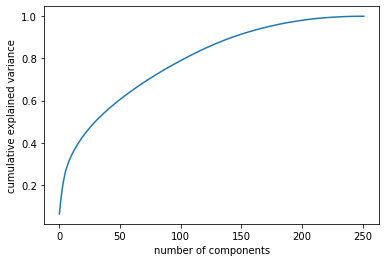

In [32]:
# Plot scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [33]:
cum_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'])
cum_variance.set_index(cum_variance.index+1, inplace=True)

print('95% threshold of variance explained by {} components.'.format(cum_variance[cum_variance['cumulative_variance']>.95].index[0]))

95% threshold of variance explained by 173 components.


173 component seems a bit high. Let's play arround with the numbers.

In [35]:
print('85% threshold of variance explained by {} components.'.format(cum_variance[cum_variance['cumulative_variance']>.85].index[0]))

85% threshold of variance explained by 123 components.


In [36]:
print('80% threshold of variance explained by {} components.'.format(cum_variance[cum_variance['cumulative_variance']>.80].index[0]))

80% threshold of variance explained by 105 components.


In [37]:
print('70% threshold of variance explained by {} components.'.format(cum_variance[cum_variance['cumulative_variance']>.70].index[0]))

70% threshold of variance explained by 75 components.


79% variance a bit low, so we can contunie with 85% variance which hits 123 components.

In [39]:
pca = PCA(n_components=123).fit(azdias_transformed)
azdias_reduced = pd.DataFrame(pca.transform(azdias_transformed))

In [100]:
def pca_top_5_feature(pca, feat_names, dim, infos):
    """ Shows top 5 important features with explanaions for desired PCA object and the given component
    input:
    pca - PCA object
    feat_names - list feature names
    dim : component number
    
    """

    fmt = lambda x: "{:.2f}%".format(x)
    sort_abs = lambda x: abs(x[0])

    names_to_weights = sorted(zip(pca.components_[dim],feat_names),key=sort_abs,reverse=True)
    names_to_weights = np.array(names_to_weights)
    importancy_df = pd.DataFrame(names_to_weights,columns=['variance','feature'])
    importancy_df['variance'] = importancy_df['variance'].astype(float)
    importancy_df['abs_variance'] = abs(importancy_df['variance'])
    importancy_df = importancy_df.sort_values(by='variance', ascending=False).head(5)
    description = infos[infos['Attribute'].isin(importancy_df.feature)]
    importancy_df = importancy_df.merge(description, how='left', left_on='feature', right_on='Attribute')
    
    return importancy_df

In [101]:
infos.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
2,Person,ANREDE_KZ,gender,modelled on millions of first name-age-reference data
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combined via a statistical modell with AZ DIAS data"
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data


### Component 1

Component 1 explains the most variance
This component mostly related with cars

In [107]:
feat_names = azdias_cleaned.columns.values

pca_top_5_feature(pca, feat_names, 0, infos)

,variance,feature,abs_variance,Information level,Attribute,Description,Additional notes
0,0.162941,KBA13_SEG_MINIWAGEN,0.162941,PLZ8,KBA13_SEG_MINIWAGEN,share of minicars within the PLZ8,modelled on different AZ DIAS data
1,0.137401,KBA13_KW_40,0.137401,PLZ8,KBA13_KW_40,share of cars with an engine power between 31 and 40 KW - PLZ8,modelled on different AZ DIAS data
2,0.134786,KBA13_FAB_ASIEN,0.134786,PLZ8,KBA13_FAB_ASIEN,share of other Asian Manufacturers within the PLZ8,modelled on different AZ DIAS data
3,0.130934,KBA13_KMH_180,0.130934,PLZ8,KBA13_KMH_180,share of cars with max speed between 110 km/h and 180km/h within the PLZ8,modelled on different AZ DIAS data
4,0.123687,KBA13_CCM_1600,0.123687,PLZ8,KBA13_CCM_1600,share of cars with 1500ccm to 1599ccm within the PLZ8,modelled on different AZ DIAS data


### Component 2

Component includes mixed infos from household to building. All have positive relationship. Social minded indicates lowest affinity

In [109]:
pca_top_5_feature(pca, feat_names, 1, infos)

,variance,feature,abs_variance,Information level,Attribute,Description,Additional notes
0,0.207102,D19_VERSI_ONLINE_DATUM,0.207102,Household,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segment insurance ONLINE,"AZ has access to approx. 650 Million transaction data - this is the basis for the criteria family DHT4A aka. D19. This data contains unique data regarding the mail-order activity of consumers, differentiated"
1,0.206702,D19_WEIN_FEINKOST,0.206702,NaN,NaN,NaN,NaN
2,0.200778,MIN_GEBAEUDEJAHR,0.200778,Building,MIN_GEBAEUDEJAHR,year the building was first mentioned in our database,additional costs
3,0.196148,KBA13_BJ_2008,0.196148,PLZ8,KBA13_BJ_2008,share of cars built in 2008 within the PLZ8,modelled on different AZ DIAS data
4,0.182259,SEMIO_SOZ,0.182259,Person,SEMIO_SOZ,affinity indicating in what way the person is social minded,attributes in cooperation with Kantar TNS; the information basis is a consumer survey


### Component 3

Interestingly again car related feature domintes this component with positive relationship. High  sensual minded means lowest affinity

In [111]:
pca_top_5_feature(pca, feat_names, 2, infos)

,variance,feature,abs_variance,Information level,Attribute,Description,Additional notes
0,0.165113,KBA13_HERST_FORD_OPEL,0.165113,PLZ8,KBA13_HERST_FORD_OPEL,share of Ford & Opel/Vauxhall within the PLZ8,modelled on different AZ DIAS data
1,0.140978,KBA13_HERST_ASIEN,0.140978,PLZ8,KBA13_HERST_ASIEN,share of asian cars within the PLZ8,modelled on different AZ DIAS data
2,0.135548,SEMIO_LUST,0.135548,Person,SEMIO_LUST,affinity indicating in what way the person is sensual minded,attributes in cooperation with Kantar TNS; the information basis is a consumer survey
3,0.131601,KBA13_SEG_KOMPAKTKLASSE,0.131601,PLZ8,KBA13_SEG_KOMPAKTKLASSE,share of lowe midclass cars (Ford Focus etc.) in the PLZ8,modelled on different AZ DIAS data
4,0.127951,KBA13_HERST_AUDI_VW,0.127951,PLZ8,KBA13_HERST_AUDI_VW,share of Volkswagen & Audi within the PLZ8,modelled on different AZ DIAS data


In [72]:
pca.explained_variance_ratio_[:3].sum()

0.16917903888296226

Cumulatively, they only explain approx. 17% of variance from our features. It seems that having a car dominates all components

## Part 1.3:Clustering

Below I will use sklearn's KMeans clustering algorithm to identify different segments of the data.

In KMeans clustering we have to choose the number of clusters that the algorithm will find. This can be difficult since we don't know how many clusters exist. So we have to choose number of clusters with elbow method.

In [117]:
sse = []
list_k = list(range(1, 31))

for k in list_k:
    km = KMeans(n_clusters=k, init='k-means++')
    km.fit(azdias_reduced.sample(20000))
    sse.append(km.inertia_)

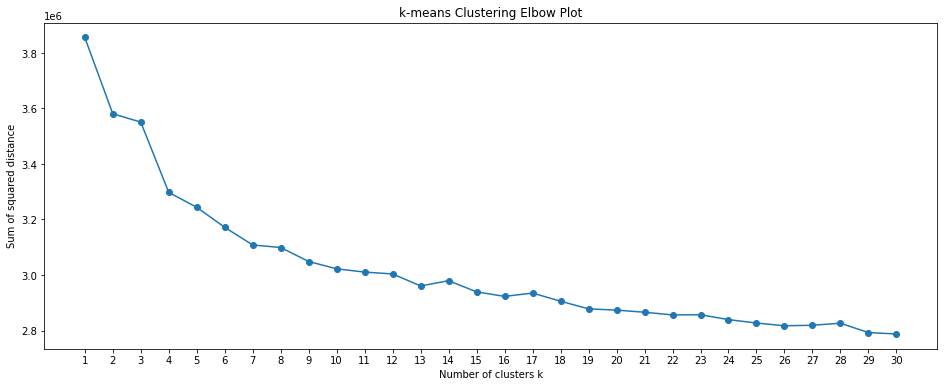

In [118]:
# Plot sse against k
plt.figure(figsize=(16, 6))
plt.plot(list_k, sse, '-o')
plt.title('k-means Clustering Elbow Plot')
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared distance")
plt.xticks(list(range(1,31)))
plt.savefig('elbow_plot.png', dpi=500);

There is no certain elbow in the graph however it seems that there is slopw decrease after 13th cluster. 

# Prepare customers data

In [132]:
# Set PCA and KMeans parameters
pca_components = 123
kmeans_clusters = 13

# Create cluster pipeline
cluster_pipeline = Pipeline([
    ('transform', column_transformer),
    ('reduce', PCA(n_components = pca_components)),
    ('cluster', KMeans(n_clusters = kmeans_clusters, init = 'k-means++'))
])

In [133]:
# Fit cluster pipeline and create clustered general population dataframe

cluster_pipeline.fit(azdias_cleaned)
azdias_clustered = pd.DataFrame(cluster_pipeline.predict(azdias_cleaned), columns = ['Cluster'])

In [134]:
# Create clustered customers dataframe
customers_cleaned = data_cleaning(customers, values)
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customers_cleaned), columns = ['Cluster'])

Number of attributes to be dropped: 138
Number of rows to be dropped: 56508


In [135]:
#Save resulsts took too long running clsutering functions
azdias_clustered.to_pickle('azdias_clustered')
customers_clustered.to_pickle('customers_clustered')
#azdias_clustered = pd.read_pickle('azdias_clustered')
#customers_clustered = pd.read_pickle('customers_clustered')

In [136]:
# Get cluster sizes in each dataset
population_clusters = azdias_clustered['Cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

# Concat both dataframes to one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

# Calculate share of each cluster
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()*100
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()*100
clusters['diff_share'] = clusters['customers_share'] - clusters['population_share']

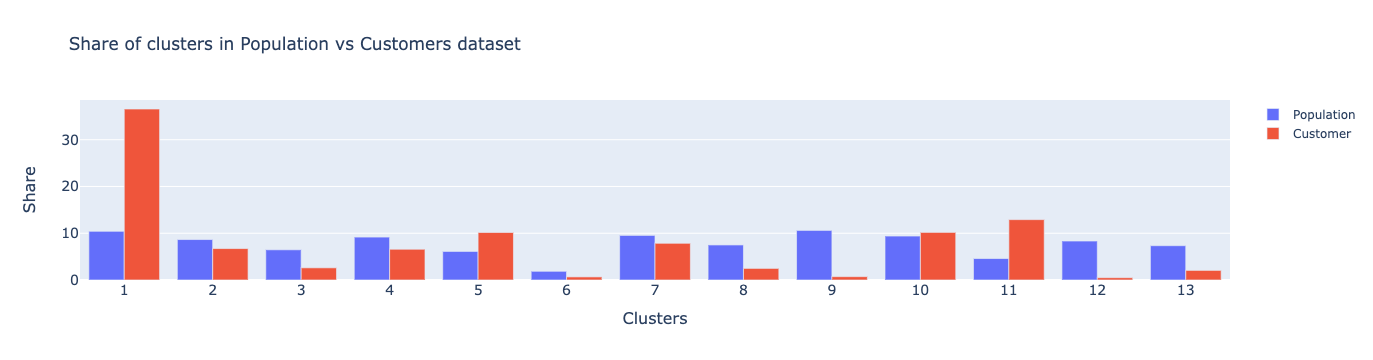

In [137]:
fig = go.Figure(data=[
    go.Bar(name='Population', x=clusters.cluster.astype(str), y=clusters.population_share),
    go.Bar(name='Customer', x=clusters.cluster.astype(str), y=clusters.customers_share)
])
# Change the bar mode
fig.update_layout(barmode='group',
                  title_text='Share of clusters in Population vs Customers dataset',
                  yaxis=dict(
                        title='Share',
                        titlefont_size=16,
                        tickfont_size=14,
                  ),
                  xaxis=dict(
                        title='Clusters',
                        titlefont_size=16,
                        tickfont_size=14,
                  ),
                 )
fig.show()

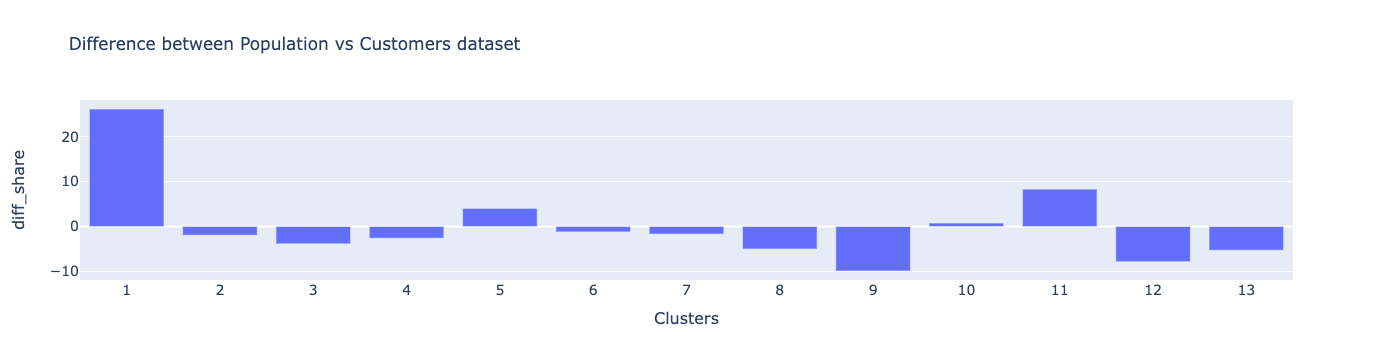

In [139]:
fig = go.Figure(data=[
    go.Bar(name='Population', x=clusters.cluster.astype(str), y=clusters.diff_share)
])
# Change the bar mode
fig.update_layout(barmode='group',
                  title_text='Difference between Population vs Customers dataset',
                  yaxis=dict(
                        title='diff_share',
                        titlefont_size=16,
                        tickfont_size=14,
                  ),
                  xaxis=dict(
                        title='Clusters',
                        titlefont_size=16,
                        tickfont_size=14,
                  ),
                 )
fig.show()

It seems that 1st group targetted most. 11th, 5th and 10th clusters folow it accordingly. 9th cluster customers are outside of the company focus group because they are dominating population but not in compnies customer segment. 12th and 13th groups folow it accordingly.

Let's look at clusters's details to understand the groups behavior

In [142]:
def get_clusters_attributes(cluster_pipeline, numerical_cols, column_names):
    """
    Function transforms clusters centers, by performin pca inverse transform,reverse scale for numerical(num_attributes) 
    
    Input:
        cluster_pipeline: object of cluster_pipeline
        num_attributes: list of numerical attributes which were rescaled
        column_names: names of all columns after Column Transformer operation
        
        
    Output:
        cluster_centers_df (DataFrame): DataFrame of cluster_centers with their attributes values
        
    """

    pca_components = cluster_pipeline.named_steps['reduce']
    kmeans = cluster_pipeline.named_steps['cluster']
    transformer =  cluster_pipeline.named_steps['transform']

    cluster_centers = pca_components.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=column_names)

    num_scale = transformer.named_transformers_['numerical'].named_steps['num_scale']
    cluster_centers_df[numerical_cols] = num_scale.inverse_transform(cluster_centers_df[numerical_cols])

    return cluster_centers_df 

In [172]:
numerical_cols = list(set(azdias_cleaned.columns) - set(binary_cols) - set(categorical_cols))
dummy_cols = list(column_transformer.transformers_[1][1].named_steps['onehot'].get_feature_names(categorical_cols))
column_names = set(numerical_cols) | set(binary_cols) | set(dummy_cols)
cluster_centers_df = get_clusters_attributes(cluster_pipeline, numerical_cols, column_names)

In [194]:
comparison_df = cluster_centers_df.T[[1,11,9,12]]

In [195]:
comparison_df.columns=['interested_cluster_1','interested_cluster_11','not_interested_cluster_9','not_interested_cluster_12']

In [196]:
comparison_df = comparison_df.reset_index()
comparison_df.columns = ['Attribute', 'interested_cluster_1', 'interested_cluster_11',
       'not_interested_cluster_9', 'not_interested_cluster_12']
comparison_df[comparison_df.std(axis=1)>2]

/var/folders/qq/dtt36pfs05b4gm5l8vjdk1bc0000gn/T/ipykernel_94728/1611094902.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Attribute,interested_cluster_1,interested_cluster_11,not_interested_cluster_9,not_interested_cluster_12
17,LNR,655026.752720,652236.260177,649125.931917,656533.384413
40,EINGEZOGENAM_HH_JAHR,2005.234318,2004.746256,2002.984422,1998.153626
55,ANZ_HAUSHALTE_AKTIV,6.013276,10.585922,6.216955,7.297482
67,ALTER_HH,10.632381,13.574433,9.114098,12.818555
83,GEBURTSJAHR,679.955966,595.566755,2123.094327,217.495125
84,KBA13_ANZAHL_PKW,631.058996,687.242565,467.580051,786.378252


In [200]:
comparison_df[comparison_df.std(axis=1)>2].merge(values, how='left', on='Attribute')

/var/folders/qq/dtt36pfs05b4gm5l8vjdk1bc0000gn/T/ipykernel_94728/4240380525.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Attribute,interested_cluster_1,interested_cluster_11,not_interested_cluster_9,not_interested_cluster_12,Description,Value,Meaning
0,LNR,655026.752720,652236.260177,649125.931917,656533.384413,NaN,NaN,NaN
1,EINGEZOGENAM_HH_JAHR,2005.234318,2004.746256,2002.984422,1998.153626,NaN,NaN,NaN
2,ANZ_HAUSHALTE_AKTIV,6.013276,10.585922,6.216955,7.297482,number of households in the building,…,numeric value (typically coded from 1-10)
3,ALTER_HH,10.632381,13.574433,9.114098,12.818555,main age within the household,0,unknown / no main age detectable
4,ALTER_HH,10.632381,13.574433,9.114098,12.818555,main age within the household,1,01.01.1895 bis 31.12.1899
5,ALTER_HH,10.632381,13.574433,9.114098,12.818555,main age within the household,2,01.01.1900 bis 31.12.1904
6,ALTER_HH,10.632381,13.574433,9.114098,12.818555,main age within the household,3,01.01.1905 bis 31.12.1909
7,ALTER_HH,10.632381,13.574433,9.114098,12.818555,main age within the household,4,01.01.1910 bis 31.12.1914
8,ALTER_HH,10.632381,13.574433,9.114098,12.818555,main age within the household,5,01.01.1915 bis 31.12.1919
9,ALTER_HH,10.632381,13.574433,9.114098,12.818555,main age within the household,6,01.01.1920 bis 31.12.1924


Clusters are very close to each other so to be able to interpret correctly I will focus on most focussed and unfocussed groups whic are cluster 1 and cluster 9.

It seems that marketing team mostly focus on younger groups and who have cars.

<a id='part2'></a>
## Part 2: Supervised Learning Model

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, we will verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

I will only apply XGBoost model due to time contraint and memory issues. I will try to invest time on hyperparameter tunning

In [205]:
mailout_train_cleaned = data_cleaning(mailout_train, values)
mailout_test_cleaned = data_cleaning(mailout_test, values, is_test_df=True)

Number of attributes to be dropped: 135
Number of rows to be dropped: 8748
Number of attributes to be dropped: 135
Number of rows to be dropped: 0


In [231]:
X = mailout_train_cleaned.drop(['RESPONSE','CAMEO_DEUG_2015', 'OST_WEST_KZ'], axis=1)
y = mailout_train_cleaned['RESPONSE']


feature_names = X.columns


In [240]:
mailout_train_cleaned['RESPONSE'].value_counts()

0    33790
1      424
Name: RESPONSE, dtype: int64

In [232]:
sum(y)/len(y)

0.012392587829543462

We have unbalanced dataset let's do strafied sampling.

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
#test strafied sampling
print('Odds Ratio - Train dataset:{}'.format(sum(y_train)/len(y_train)))
print('Odds Ratio - Test dataset:{}'.format(sum(y_test)/len(y_test)))

Odds Ratio - Train dataset:0.012392829306313328
Odds Ratio - Test dataset:0.012391863455693243


### Build A Prelimnary XGBoost Model

In [235]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, use_label_encoder=False)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.01239
[1]	validation_0-aucpr:0.01574
[2]	validation_0-aucpr:0.01564
[3]	validation_0-aucpr:0.01515
[4]	validation_0-aucpr:0.01468
[5]	validation_0-aucpr:0.01436
[6]	validation_0-aucpr:0.01486
[7]	validation_0-aucpr:0.01367
[8]	validation_0-aucpr:0.01353
[9]	validation_0-aucpr:0.01311
[10]	validation_0-aucpr:0.01339
[11]	validation_0-aucpr:0.01395


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Classification report (Test): 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8448
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8554
   macro avg       0.49      0.50      0.50      8554
weighted avg       0.98      0.99      0.98      8554


Train Accuracy: 0.9876071706936866
Test Accuracy: 0.9876081365443068

Train Recall: 0.0
Test Recall: 0.0

Confusion matrix (Test): 



/Users/esraari/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/esraari/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/esraari/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



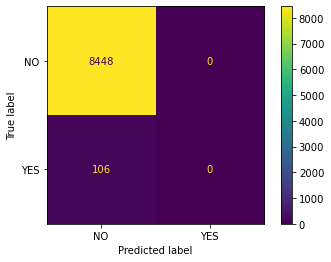

In [241]:

#Generate predictions against our training and test data
pred_train = clf_xgb.predict(X_train)
proba_train = clf_xgb.predict_proba(X_train)
pred_test = clf_xgb.predict(X_test)
proba_test = clf_xgb.predict_proba(X_test)


# Print model report
print("Classification report (Test): \n")
print(metrics.classification_report(y_test, pred_test))


print ('\nTrain Accuracy:', metrics.accuracy_score(y_train, pred_train))
print ('Test Accuracy:', metrics.accuracy_score(y_test, pred_test))


print ('\nTrain Recall:', metrics.recall_score(y_train, pred_train))
print ('Test Recall:', metrics.recall_score(y_test, pred_test))

print("\nConfusion matrix (Test): \n")
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels=["NO", "YES"])

It seems that the model tend to say customer will not answer. Let's play around parameters a littel bit. My biggest hesitaion is about having unbalanced dataset.

In [248]:
# For imbalanced dataset, let's find out scale_pos_weight. It is documented that it is better to use if there is imbalanced data.
# scale_pos_weight = total_negative_examples / total_positive_examples

len(mailout_train_cleaned[mailout_train_cleaned['RESPONSE']==0]) / len(mailout_train_cleaned[mailout_train_cleaned['RESPONSE']==1])

79.69339622641509

In [254]:
%%time 
#Round 1
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.06],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [79, 79.69, 80]
}
# {'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 0, 'scale_pos_weight': 80}





clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42, 
                            use_label_encoder=False,
                            subsample=0.9,
                            colsample_bytree=0.5
                           )

optimal_params = GridSearchCV(estimator=clf_xgb,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              verbose=2,
                              n_jobs=10,
                              cv=3
                             )

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False
                  )
print(optimal_params.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
{'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 0, 'scale_pos_weight': 80}
CPU times: user 15.4 s, sys: 7.99 s, total: 23.3 s
Wall time: 13min 17s


In [255]:
%%time
#Round 1
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.06],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [79, 79.69, 80]
}
# {'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 0, 'scale_pos_weight': 80}

#Round 2
param_grid = {
    'max_depth': [1, 2],
    'learning_rate': [0.05],
    'gamma': [1.0, 10, 20],
    'reg_lambda': [0],
    'scale_pos_weight': [80]
}
# {'gamma': 0, 'learning_rate': 0.8, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 0.13}




clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42, 
                            use_label_encoder=False,
                            subsample=0.9,
                            colsample_bytree=0.5
                           )

optimal_params = GridSearchCV(estimator=clf_xgb,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              verbose=2,
                              n_jobs=10,
                              cv=3
                             )

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False
                  )
print(optimal_params.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'reg_lambda': 0, 'scale_pos_weight': 80}
CPU times: user 10.3 s, sys: 1.31 s, total: 11.6 s
Wall time: 14.2 s


In [256]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42, 
                            use_label_encoder=False,
                            gamma=1,
                            learning_rate=0.05,
                            max_depth=2,
                            reg_lambda=0,
                            scale_pos_weight=80,
                            subsample=0.9,
                            colsample_bytree=0.5
                            
                           )
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.01507
[1]	validation_0-aucpr:0.01542
[2]	validation_0-aucpr:0.01650
[3]	validation_0-aucpr:0.01602
[4]	validation_0-aucpr:0.01614
[5]	validation_0-aucpr:0.01616
[6]	validation_0-aucpr:0.01589
[7]	validation_0-aucpr:0.01612
[8]	validation_0-aucpr:0.01547
[9]	validation_0-aucpr:0.01550
[10]	validation_0-aucpr:0.01540
[11]	validation_0-aucpr:0.01606
[12]	validation_0-aucpr:0.01660
[13]	validation_0-aucpr:0.01613
[14]	validation_0-aucpr:0.01646
[15]	validation_0-aucpr:0.01643
[16]	validation_0-aucpr:0.01638
[17]	validation_0-aucpr:0.01563
[18]	validation_0-aucpr:0.01566
[19]	validation_0-aucpr:0.01572
[20]	validation_0-aucpr:0.01592
[21]	validation_0-aucpr:0.01628


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=80,
              seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Classification report (Test): 

              precision    recall  f1-score   support

           0       0.99      0.55      0.71      8448
           1       0.02      0.61      0.03       106

    accuracy                           0.55      8554
   macro avg       0.50      0.58      0.37      8554
weighted avg       0.98      0.55      0.70      8554


Train Accuracy: 0.5563133281371785
Test Accuracy: 0.5516717325227963

Train Recall: 0.720125786163522
Test Recall: 0.6132075471698113

Confusion matrix (Test): 



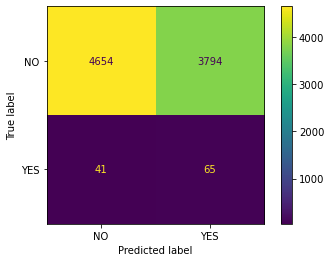

In [257]:

#Generate predictions against our training and test data
pred_train = clf_xgb.predict(X_train)
proba_train = clf_xgb.predict_proba(X_train)
pred_test = clf_xgb.predict(X_test)
proba_test = clf_xgb.predict_proba(X_test)



# Print model report
print("Classification report (Test): \n")
print(metrics.classification_report(y_test, pred_test))


print ('\nTrain Accuracy:', metrics.accuracy_score(y_train, pred_train))
print ('Test Accuracy:', metrics.accuracy_score(y_test, pred_test))


print ('\nTrain Recall:', metrics.recall_score(y_train, pred_train))
print ('Test Recall:', metrics.recall_score(y_test, pred_test))

print("\nConfusion matrix (Test): \n")
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels=["NO", "YES"])

Let's Run the algorithm on test dataset which I have prefered the call it out of time test data

In [271]:

# Save to file in the current working directory
pkl_filename = "best_clf_xgb.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(clf_xgb, file)
    
# Load from file
pkl_filename = "best_clf_xgb.pkl"  
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file) 

In [272]:
test_oot = mailout_test_cleaned.drop(['CAMEO_DEUG_2015', 'OST_WEST_KZ'], axis=1)

In [273]:
pred_test_oot = pickle_model.predict(test_oot)
proba_test_oot = pickle_model.predict_proba(test_oot)

In [274]:
pred_test.sum()

3859

In [275]:
len(pred_test)

8554

It seems that algorithm found 3859 customer that can be contacted.